In [2]:
!apt install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cuda-11-5 cuda-cccl-11-5 cuda-command-line-tools-11-5 cuda-compiler-11-5
  cuda-cudart-11-5 cuda-cudart-dev-11-5 cuda-cuobjdump-11-5 cuda-cupti-11-5
  cuda-cupti-dev-11-5 cuda-cuxxfilt-11-5 cuda-demo-suite-11-5
  cuda-documentation-11-5 cuda-driver-dev-11-5 cuda-gdb-11-5
  cuda-libraries-11-5 cuda-libraries-dev-11-5 cuda-memcheck-11-5
  cuda-nsight-11-5 cuda-nsight-compute-11-5 cuda-nsight-systems-11-5
  cuda-nvcc-11-5 cuda-nvdisasm-11-5 cuda-nvml-dev-11-5 cuda-nvprof-11-5
  cuda-nvprune-11-5 cuda-nvrtc-11-5 cuda-nvrtc-dev-11-5 cuda-nvtx-11-5
  cuda-nvvp-11-5 cuda-runtime-11-5 cuda-samples-11-5 cuda-sanitizer-11-5
  cuda-toolkit-11-5 cuda-toolkit-11-5-config-common
  cuda-toolkit-11-config-common cuda-toolkit-config-common cuda-tools-11-5
  cuda-visual-tools-11-5 gds-tools-11-5 libcublas-11-5 libcublas-dev-11-5
  libcufft-11-5 libcufft-d

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [4]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 13 22:54:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-1-01 00:00:00']

In [7]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [8]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
1,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
2,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
3,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
4,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.35,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,NaN,NaN,NaN,5.33,3.93,3.85,6.58,6.73,NaN,1.87,10.78,10.60,21.62,21.37,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,16.75,16.45,10.78,10.95,6.43,7.02,16.57,16.53,4.12,4.25,3.57,3.52,NaN,NaN,10.83,...,17.18,17.52,12.40,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.95,13.97,15.32

In [9]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.90,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55868,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55869,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55870,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72


In [10]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [11]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,travel_time_9,travel_time_10,travel_time_11,travel_time_12,travel_time_13,travel_time_14,travel_time_15,travel_time_16,travel_time_17,travel_time_18,travel_time_19,travel_time_20,travel_time_21,travel_time_22,travel_time_23,travel_time_24,travel_time_25,travel_time_26,travel_time_27,travel_time_28,travel_time_29,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39,travel_time_40
0,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
5,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
6,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
7,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
8,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80
9,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80


In [12]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
print(total_data)

       travel_time_0  travel_time_1  ...  travel_time_39  travel_time_40
0              10.90          11.55  ...           15.75           15.78
1              10.90          11.55  ...           15.75           15.78
2              10.90          11.55  ...           15.75           15.78
3              10.90          11.55  ...           15.75           15.78
4              10.90          11.55  ...           15.75           15.78
...              ...            ...  ...             ...             ...
55867          10.88          11.60  ...           15.70           15.72
55868          10.88          11.60  ...           15.70           15.72
55869          10.88          11.60  ...           15.70           15.72
55870          10.88          11.60  ...           15.70           15.72
55871          10.88          11.60  ...           15.70           15.72

[55872 rows x 41 columns]


In [13]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(total_data)
# train = scaler.transform(train_data)
total = scaler.transform(total_data)

sc = MinMaxScaler()
total_data = sc.fit_transform(total_data)

## 15 minutes horizon
trn_x, trn_y = make_dataset_many_to_one(total, time_steps, num_training)  
vld_x, vld_y = make_dataset_many_to_one(total, time_steps, num_validate)  
tst_x, tst_y = make_dataset_many_to_one(total, time_steps, num_test)  

trn_x = trn_x.reshape(-1, time_steps, num_corridor)
vld_x = vld_x.reshape(-1, time_steps, num_corridor)
tst_x = tst_x.reshape(-1, time_steps, num_corridor)



In [14]:
# conver the data to tensors and pass to the Dataloader 
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [15]:
class LSTM(nn.Module):

    def __init__(self, num_corridor, seq_length, hidden_size, num_layers, drop_prob = 0.5, nfc = 512):
        super(LSTM, self).__init__()
        
        self.num_corridor = num_corridor
        self.num_layers = num_layers
        self.hidden_size = hidden_size * num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=num_corridor, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, num_corridor)

        self.output_layer =  nn.Sequential(
            nn.Linear(self.hidden_size, nfc),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(nfc, nfc),
            nn.ReLU(), 
            nn.Dropout(drop_prob),
            nn.Linear(nfc, num_corridor),
        )


    def forward(self, x):
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)
        # h_out.shape (num_layers, batch, hidden_size)
        
        h_out = torch.transpose(h_out, 1, 0)

        h_out = h_out.reshape(-1, self.hidden_size)
        
        out = self.output_layer(h_out)
        
        return out

## Test Pytorch Training Speed

In [16]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x)))
trainY = Variable(torch.Tensor(np.array(trn_y)))

vldtX = Variable(torch.Tensor(np.array(vld_x)))
vldtY = Variable(torch.Tensor(np.array(vld_y)))

testX = Variable(torch.Tensor(np.array(tst_x)))
testY = Variable(torch.Tensor(np.array(tst_y)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch
        # print("targets shape", targets.shape)
        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)
        model = model.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        # print(y_pred.shape)
        loss = criterion(y_pred, targets)
        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print("*"*100) 
print('time %.2f sec' % (end-start))

epoch: 10 | trn_loss: 0.00106842 val_loss: 0.00055799 
epoch: 20 | trn_loss: 0.00093830 val_loss: 0.00041593 
epoch: 30 | trn_loss: 0.00090064 val_loss: 0.00038172 
epoch: 40 | trn_loss: 0.00086296 val_loss: 0.00040634 
epoch: 50 | trn_loss: 0.00083946 val_loss: 0.00042701 
epoch: 60 | trn_loss: 0.00084320 val_loss: 0.00037000 
epoch: 70 | trn_loss: 0.00081531 val_loss: 0.00037753 
epoch: 80 | trn_loss: 0.00085063 val_loss: 0.00042100 
epoch: 90 | trn_loss: 0.00079331 val_loss: 0.00040305 
epoch: 100 | trn_loss: 0.00081180 val_loss: 0.00035380 
epoch: 110 | trn_loss: 0.00079434 val_loss: 0.00029133 
epoch: 120 | trn_loss: 0.00079025 val_loss: 0.00034156 
epoch: 130 | trn_loss: 0.00079325 val_loss: 0.00034002 
epoch: 140 | trn_loss: 0.00078897 val_loss: 0.00033083 
epoch: 150 | trn_loss: 0.00079053 val_loss: 0.00037547 
epoch: 160 | trn_loss: 0.00076495 val_loss: 0.00032068 
epoch: 170 | trn_loss: 0.00075283 val_loss: 0.00033429 
epoch: 180 | trn_loss: 0.00077758 val_loss: 0.00033915 
e

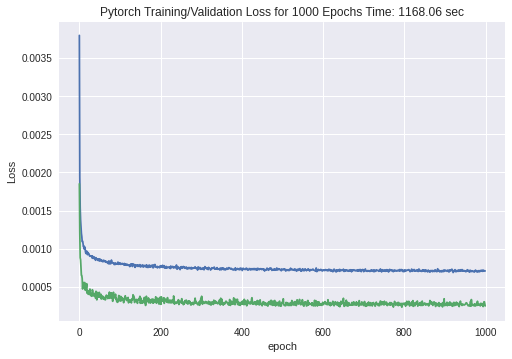

In [22]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title(f'Pytorch Training/Validation Loss for {num_epochs} Epochs Time: {round(end-start, 2)} sec')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()